In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
dftaxi=pd.read_csv("../data/final.csv")
print dftaxi.shape

(23409, 19)


In [3]:
itrain, itest = train_test_split(xrange(dftaxi.shape[0]), train_size=0.6)
mask=np.ones(dftaxi.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [4]:
X = dftaxi.iloc[:,3:18]
y = np.log10(dftaxi['freq']+1)

In [5]:
Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
print Xtrain.shape
Xtrain.head()

(14045, 15)


,hour,weekday,ZIPCODE,Battery Park City,Commerical,Manufacturing,Manufacturing/Residential,Park,Residential,precipitation,snow_depth,snowfall,max_temp,min_temp,avg_wind
5,8,4,10035,0.0,12.0,0.0,7.0,13.0,16.0,0.000,0.0,0.0,8.7,7.0,0.720
10,20,6,10035,0.0,12.0,0.0,7.0,13.0,16.0,0.000,0.0,0.0,9.3,7.8,1.116
11,22,3,10035,0.0,12.0,0.0,7.0,13.0,16.0,0.000,0.0,0.0,8.6,6.8,1.368
12,16,3,10035,0.0,12.0,0.0,7.0,13.0,16.0,0.000,0.0,0.0,8.0,6.9,0.396
15,16,2,10035,0.0,12.0,0.0,7.0,13.0,16.0,0.039,0.0,0.0,8.2,6.9,1.548


In [6]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [7]:
knn_estimator = KNeighborsRegressor()

In [8]:
knn_parameters = {"n_neighbors": [1,2,5,7,9,12,16,20]}
knn_best = cv_optimize(knn_estimator, knn_parameters, Xtrain, ytrain, score_func='neg_mean_squared_error')

BEST {'n_neighbors': 20} -0.681926649922 [mean: -0.73154, std: 0.18579, params: {'n_neighbors': 1}, mean: -0.71971, std: 0.18791, params: {'n_neighbors': 2}, mean: -0.70547, std: 0.18657, params: {'n_neighbors': 5}, mean: -0.70015, std: 0.18700, params: {'n_neighbors': 7}, mean: -0.69572, std: 0.18926, params: {'n_neighbors': 9}, mean: -0.69142, std: 0.19286, params: {'n_neighbors': 12}, mean: -0.68635, std: 0.19708, params: {'n_neighbors': 16}, mean: -0.68193, std: 0.20047, params: {'n_neighbors': 20}]


In [9]:
knn_reg=knn_best.fit(Xtrain, ytrain)
knn_training_accuracy = knn_reg.score(Xtrain, ytrain)
knn_test_accuracy = knn_reg.score(Xtest, ytest)
print "############# based on standard predict ################"
print "R^2 on training data: %0.4f" % (knn_training_accuracy)
print "R^2 on test data:     %0.4f" % (knn_test_accuracy)

############# based on standard predict ################
R^2 on training data: 0.9417
R^2 on test data:     0.9362


In [10]:
np.sqrt(mean_squared_error(knn_reg.predict(Xtest),ytest))

0.20353355407400214

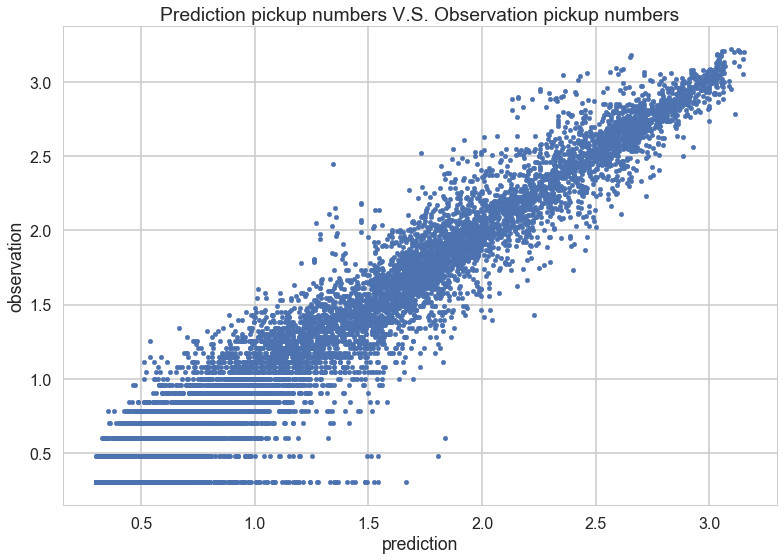

In [11]:
preds = pd.DataFrame({"prediction":knn_reg.predict(Xtest), "observation":ytest})
preds.plot(x = "prediction", y = "observation",kind = "scatter", title = "Prediction pickup numbers V.S. Observation pickup numbers")